# Introduction


Focus of this Lab is to determine how various preprocessing techniques such as Histogram Equalization, De-noising, Segmentation, Orientation estimation and Ridge orientation, and Applying Gabor filters on the fingerprint image to enhance the ridges on a given fingerprints.
Moreover, to understand effect of change of block_size and threshold on the fingerprints' minutiae and sigularities.



<h3>Lab 4</h3>

In [2]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

# Exercise 1

In [3]:
# Finger 1 -- Good and Bad fingerprints
right_good = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
right_bad = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/15.bmp', as_gray=True))
# Finger 2 -- Good and Bad fingerprints
left_good = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/4.bmp', as_gray=True))
left_bad = img_as_ubyte(imread('BTLab_Fingerprints/left_thumb/7.bmp', as_gray=True))

# Saving a copy for later use
input_r_good = right_good.copy()
input_r_bad = right_bad.copy()
input_l_good = left_good.copy()
input_l_bad = left_bad.copy()

print("Right (Good):", np.min(right_good), np.max(right_good))
print("Right (Bad):", np.min(right_bad), np.max(right_bad))
print("Left (Good):", np.min(left_good), np.max(left_good))
print("Left (Bad):", np.min(left_bad), np.max(left_bad))

Right (Good): 0 255
Right (Bad): 0 255
Left (Good): 0 255
Left (Bad): 0 255


#### Pre-Processing

In [4]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    orientation_img = visualize_angles(segmented_img, mask, angles, W=block_size)

    output['angles'] = angles
    output['orientation_img'] = orientation_img
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [5]:
print("Right Thumb Good Fingerprint")
processed_rg_img = fingerprint_processing(right_good, block_size=16, threshold=0.4)

print('\nRight Thumb Bad Fingerpring')
processed_rb_img = fingerprint_processing(right_bad, block_size=16, threshold=0.4)

print('\nLeft Thumb Good Fingerprint')
processed_lg_img = fingerprint_processing(left_good, block_size=16, threshold=0.4)

print('\nLeft Thumb Bad Fingerprint')
processed_lb_img = fingerprint_processing(left_bad, block_size=16, threshold=0.4)

Right Thumb Good Fingerprint
Total of minutiae detected: 47
Total of singularities detected: 4

Right Thumb Bad Fingerpring
Total of minutiae detected: 61
Total of singularities detected: 4

Left Thumb Good Fingerprint
Total of minutiae detected: 64
Total of singularities detected: 4

Left Thumb Bad Fingerprint
Total of minutiae detected: 44
Total of singularities detected: 4


#### Right Finger (Good Image)

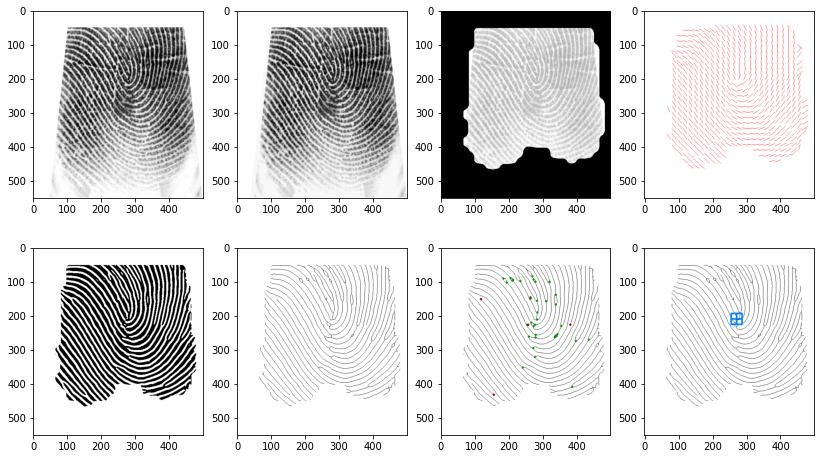

In [6]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1); plt.imshow(input_r_good, cmap='gray');
plt.subplot(2,4,2); plt.imshow(processed_rg_img['normalized_img'], cmap='gray')
plt.subplot(2,4,3); plt.imshow(processed_rg_img['segmented_img'], cmap='gray');
plt.subplot(2,4,4); plt.imshow(processed_rg_img['orientation_img']);
plt.subplot(2,4,5); plt.imshow(processed_rg_img['gabor_img'], cmap='gray');
plt.subplot(2,4,6); plt.imshow(processed_rg_img['thin_image'], cmap='gray');
plt.subplot(2,4,7); plt.imshow(processed_rg_img['minutiae_img']);
plt.subplot(2,4,8); plt.imshow(processed_rg_img['singularities_img']);

#### Right Finger (Bad Image)

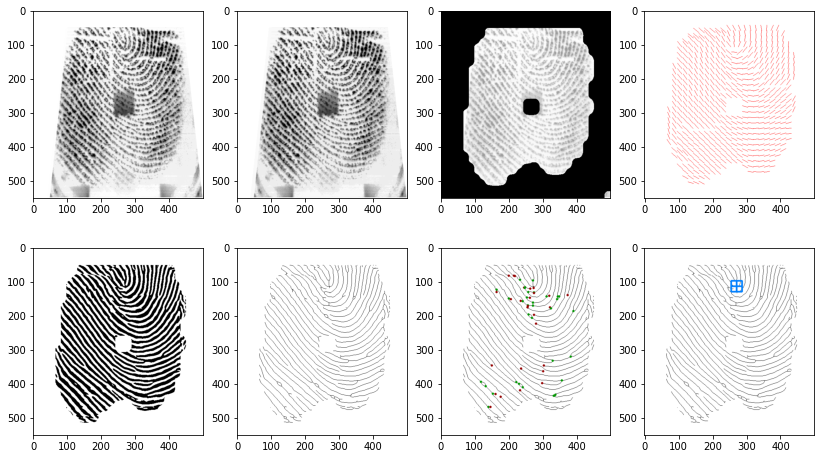

In [7]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1); plt.imshow(input_r_bad, cmap='gray');
plt.subplot(2,4,2); plt.imshow(processed_rb_img['normalized_img'], cmap='gray')
plt.subplot(2,4,3); plt.imshow(processed_rb_img['segmented_img'], cmap='gray');
plt.subplot(2,4,4); plt.imshow(processed_rb_img['orientation_img']);
plt.subplot(2,4,5); plt.imshow(processed_rb_img['gabor_img'], cmap='gray');
plt.subplot(2,4,6); plt.imshow(processed_rb_img['thin_image'], cmap='gray');
plt.subplot(2,4,7); plt.imshow(processed_rb_img['minutiae_img']);
plt.subplot(2,4,8); plt.imshow(processed_rb_img['singularities_img']);

#### Left Finger (Good Image)

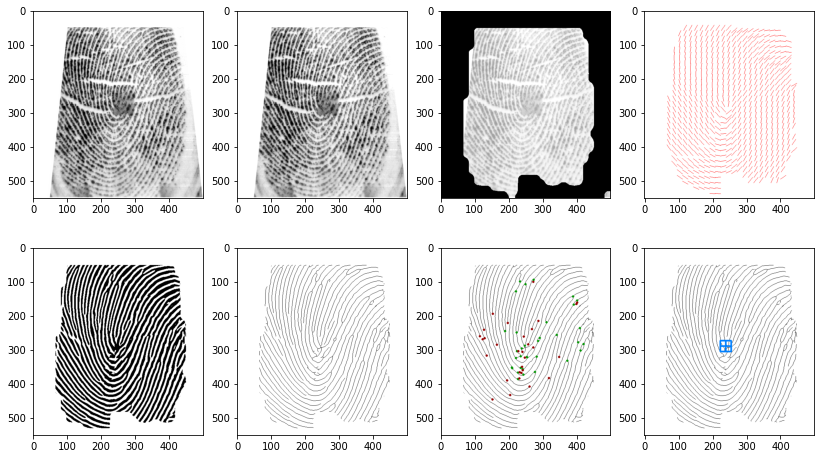

In [8]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1); plt.imshow(input_l_good, cmap='gray');
plt.subplot(2,4,2); plt.imshow(processed_lg_img['normalized_img'], cmap='gray')
plt.subplot(2,4,3); plt.imshow(processed_lg_img['segmented_img'], cmap='gray');
plt.subplot(2,4,4); plt.imshow(processed_lg_img['orientation_img']);
plt.subplot(2,4,5); plt.imshow(processed_lg_img['gabor_img'], cmap='gray');
plt.subplot(2,4,6); plt.imshow(processed_lg_img['thin_image'], cmap='gray');
plt.subplot(2,4,7); plt.imshow(processed_lg_img['minutiae_img']);
plt.subplot(2,4,8); plt.imshow(processed_lg_img['singularities_img']);

#### Left Image (Bad Image)

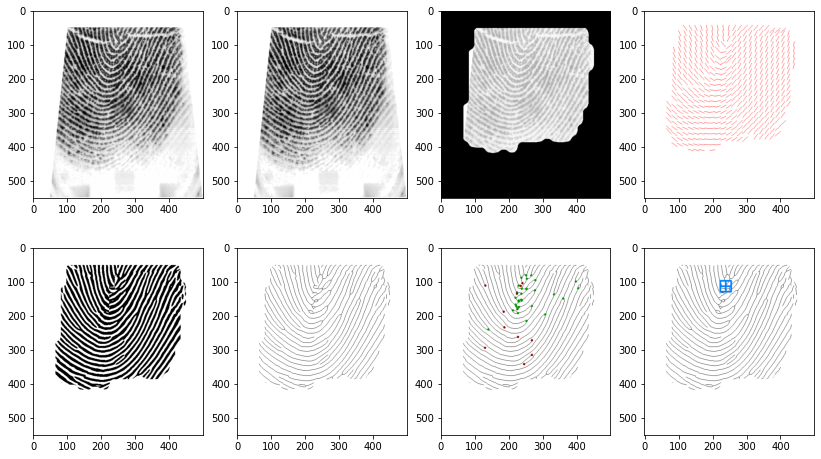

In [9]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1); plt.imshow(input_l_bad, cmap='gray');
plt.subplot(2,4,2); plt.imshow(processed_lb_img['normalized_img'], cmap='gray')
plt.subplot(2,4,3); plt.imshow(processed_lb_img['segmented_img'], cmap='gray');
plt.subplot(2,4,4); plt.imshow(processed_lb_img['orientation_img']);
plt.subplot(2,4,5); plt.imshow(processed_lb_img['gabor_img'], cmap='gray');
plt.subplot(2,4,6); plt.imshow(processed_lb_img['thin_image'], cmap='gray');
plt.subplot(2,4,7); plt.imshow(processed_lb_img['minutiae_img']);
plt.subplot(2,4,8); plt.imshow(processed_lb_img['singularities_img']);

## Histogram Equalization

#### Regular equalization

In [10]:
print('Right Thumb Good Fingerpring')
reg_right_good = img_as_ubyte(equalize_hist(right_good))
reg_eq_rg = fingerprint_processing(reg_right_good, block_size=16, threshold=0.4)

print('\nRight Thumb Bad Fingerpring')
reg_right_bad = img_as_ubyte(equalize_hist(right_bad))
reg_eq_rb = fingerprint_processing(reg_right_bad, block_size=16, threshold=0.4)

print('\nLeft Thumb Good Fingerpring')
reg_left_good = img_as_ubyte(equalize_hist(left_good))
reg_eq_lg = fingerprint_processing(reg_left_good, block_size=16, threshold=0.4)

print('\nLeft Thumb Bad Fingerpring')
reg_left_bad = img_as_ubyte(equalize_hist(left_bad))
reg_eq_lb = fingerprint_processing(reg_left_bad, block_size=16, threshold=0.4)

Right Thumb Good Fingerpring
Total of minutiae detected: 21
Total of singularities detected: 0

Right Thumb Bad Fingerpring
Total of minutiae detected: 49
Total of singularities detected: 4

Left Thumb Good Fingerpring
Total of minutiae detected: 26
Total of singularities detected: 0

Left Thumb Bad Fingerpring
Total of minutiae detected: 7
Total of singularities detected: 0


#### Adaptive Equalization

In [11]:
print('Right Thumb Good Fingerpring')
ada_right_good = img_as_ubyte(equalize_adapthist(right_good))
ada_eq_rg = fingerprint_processing(ada_right_good, block_size=16, threshold=0.4)

print('\nRight Thumb Bad Fingerpring')
ada_right_bad = img_as_ubyte(equalize_adapthist(right_bad))
ada_eq_rb = fingerprint_processing(ada_right_bad, block_size=16, threshold=0.4)

print('\nLeft Thumb Good Fingerpring')
ada_left_good = img_as_ubyte(equalize_adapthist(left_good))
ada_eq_lg = fingerprint_processing(ada_left_good, block_size=16, threshold=0.4)

print('\nLeft Thumb Bad Fingerpring')
ada_left_bad = img_as_ubyte(equalize_adapthist(left_bad))
ada_eq_lb = fingerprint_processing(ada_left_bad, block_size=16, threshold=0.4)

Right Thumb Good Fingerpring
Total of minutiae detected: 52
Total of singularities detected: 4

Right Thumb Bad Fingerpring
Total of minutiae detected: 68
Total of singularities detected: 4

Left Thumb Good Fingerpring
Total of minutiae detected: 68
Total of singularities detected: 4

Left Thumb Bad Fingerpring
Total of minutiae detected: 61
Total of singularities detected: 2


## Comparison Charts

#### Right (Good)

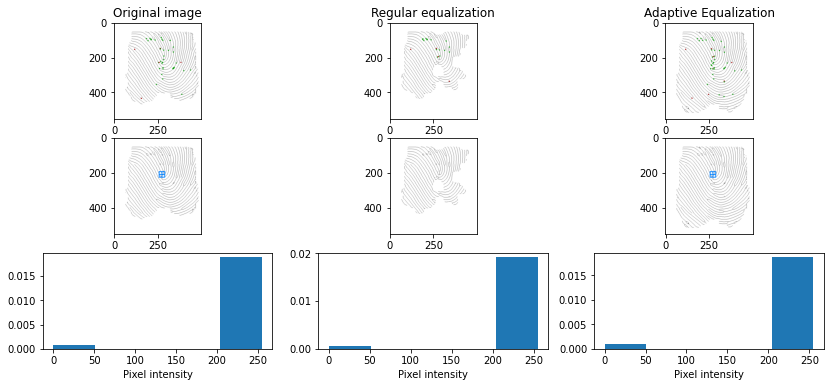

In [12]:
img = processed_rg_img['minutiae_img']
img_reg = reg_eq_rg['minutiae_img']
img_adap = ada_eq_rg['minutiae_img']

img2 = processed_rg_img['singularities_img']
img_reg2 = reg_eq_rg['singularities_img']
img_adap2 = ada_eq_rg['singularities_img']

plt.figure(figsize=(14,6))

plt.subplot(3,3,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(3,3,2)
plt.imshow(img_reg); plt.title('Regular equalization')
plt.subplot(3,3,3)
plt.imshow(img_adap); plt.title('Adaptive Equalization');

# Plotting Singularities
plt.subplot(3,3,4)
plt.imshow(img2); 
plt.subplot(3,3,5)
plt.imshow(img_reg2);
plt.subplot(3,3,6)
plt.imshow(img_adap2);

plt.subplot(3,3,7)
plt.hist(img.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(3,3,8)
plt.hist(img_reg.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(3,3,9)
plt.hist(img_adap.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity');

#### Right (Bad)

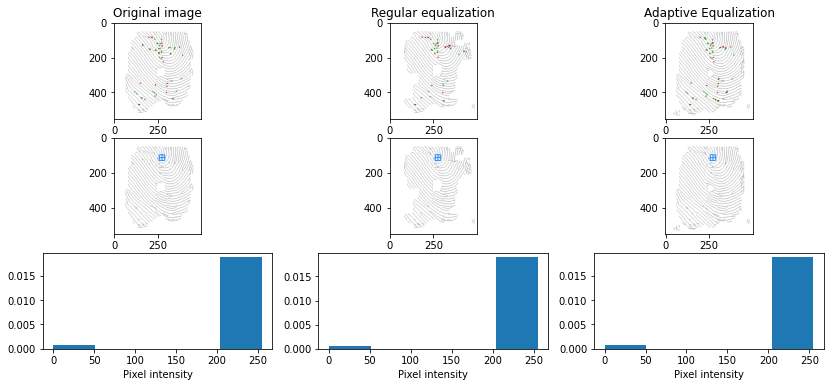

In [13]:
img = processed_rb_img['minutiae_img']
img_reg = reg_eq_rb['minutiae_img']
img_adap = ada_eq_rb['minutiae_img']

img2 = processed_rb_img['singularities_img']
img_reg2 = reg_eq_rb['singularities_img']
img_adap2 = ada_eq_rb['singularities_img']

plt.figure(figsize=(14,6))

plt.subplot(3,3,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(3,3,2)
plt.imshow(img_reg); plt.title('Regular equalization')
plt.subplot(3,3,3)
plt.imshow(img_adap); plt.title('Adaptive Equalization');

# Plotting singularities
plt.subplot(3,3,4)
plt.imshow(img2); 
plt.subplot(3,3,5)
plt.imshow(img_reg2);
plt.subplot(3,3,6)
plt.imshow(img_adap2);

plt.subplot(3,3,7)
plt.hist(img.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(3,3,8)
plt.hist(img_reg.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(3,3,9)
plt.hist(img_adap.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity');

#### Left (Good)

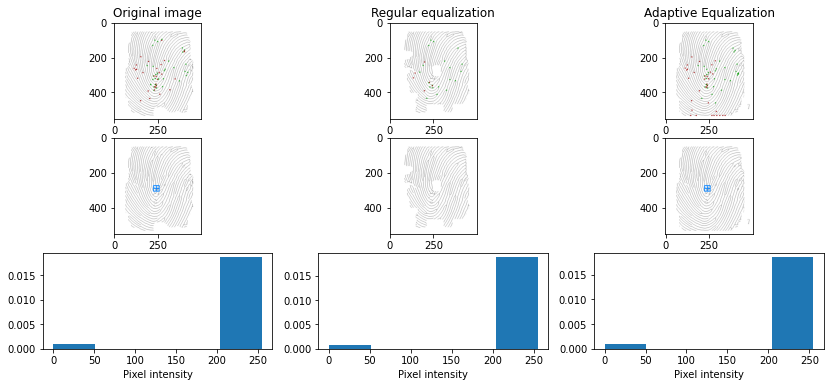

In [14]:
img = processed_lg_img['minutiae_img']
img_reg = reg_eq_lg['minutiae_img']
img_adap = ada_eq_lg['minutiae_img']

img2 = processed_lg_img['singularities_img']
img_reg2 = reg_eq_lg['singularities_img']
img_adap2 = ada_eq_lg['singularities_img']

plt.figure(figsize=(14,6))

plt.subplot(3,3,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(3,3,2)
plt.imshow(img_reg); plt.title('Regular equalization')
plt.subplot(3,3,3)
plt.imshow(img_adap); plt.title('Adaptive Equalization');

# Plotting sigularities
plt.subplot(3,3,4)
plt.imshow(img2); 
plt.subplot(3,3,5)
plt.imshow(img_reg2);
plt.subplot(3,3,6)
plt.imshow(img_adap2);

plt.subplot(3,3,7)
plt.hist(img.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(3,3,8)
plt.hist(img_reg.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(3,3,9)
plt.hist(img_adap.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity');

#### Left (Bad)

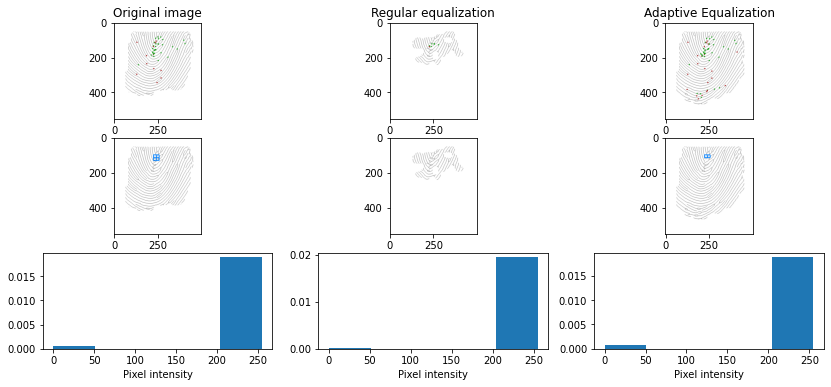

In [15]:
img = processed_lb_img['minutiae_img']
img_reg = reg_eq_lb['minutiae_img']
img_adap = ada_eq_lb['minutiae_img']

img2 = processed_lb_img['singularities_img']
img_reg2 = reg_eq_lb['singularities_img']
img_adap2 = ada_eq_lb['singularities_img']

plt.figure(figsize=(14,6))

plt.subplot(3,3,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(3,3,2)
plt.imshow(img_reg); plt.title('Regular equalization')
plt.subplot(3,3,3)
plt.imshow(img_adap); plt.title('Adaptive Equalization');

# Plotting Signularities
plt.subplot(3,3,4)
plt.imshow(img2); 
plt.subplot(3,3,5)
plt.imshow(img_reg2);
plt.subplot(3,3,6)
plt.imshow(img_adap2);

plt.subplot(3,3,7)
plt.hist(img.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(3,3,8)
plt.hist(img_reg.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(3,3,9)
plt.hist(img_adap.ravel(), bins=5, density=True)
plt.xlabel('Pixel intensity');

### Conclusion (Ex.1)

*Regular* -
From the above results we can see that the histogram equalization decreases the number of mineutia while number of singularities becomes 0 in almost all cases.

*Adaptive* -
From the above results we can see that the adaptive histogram equalization increases the number of mineutia in almost all cases however it can be observed that it does the impact the number of singularities.

## Exercise 2

#### After de-noising (using same preprocessed fingerprints from Exercise 1)

In [16]:
# Getting medians
right_good_median = median(right_good)
right_bad_median = median(right_bad)

left_good_median = median(left_good)
left_bad_median = median(left_bad)

In [17]:
print("Right Thumb Good Fingerprint")
processed_rg_img = fingerprint_processing(right_good_median, block_size=16, threshold=0.4)

print('\nRight Thumb Bad Fingerpring')
processed_rb_img = fingerprint_processing(right_bad_median, block_size=16, threshold=0.4)

print('\nLeft Thumb Good Fingerprint')
processed_lg_img = fingerprint_processing(left_good_median, block_size=16, threshold=0.4)

print('\nLeft Thumb Bad Fingerprint')
processed_lb_img = fingerprint_processing(left_bad_median, block_size=16, threshold=0.4)

Right Thumb Good Fingerprint
Total of minutiae detected: 32
Total of singularities detected: 4

Right Thumb Bad Fingerpring
Total of minutiae detected: 50
Total of singularities detected: 4

Left Thumb Good Fingerprint
Total of minutiae detected: 55
Total of singularities detected: 4

Left Thumb Bad Fingerprint
Total of minutiae detected: 39
Total of singularities detected: 4


#### Right (Good)

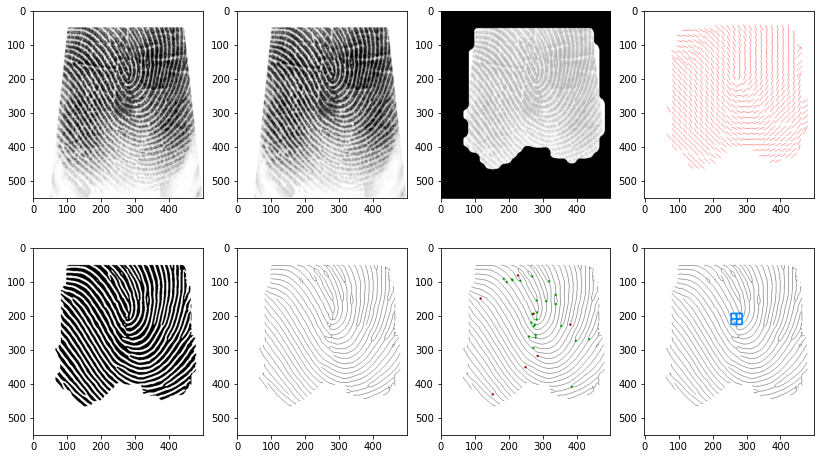

In [18]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1); plt.imshow(input_r_good, cmap='gray');
plt.subplot(2,4,2); plt.imshow(processed_rg_img['normalized_img'], cmap='gray')
plt.subplot(2,4,3); plt.imshow(processed_rg_img['segmented_img'], cmap='gray');
plt.subplot(2,4,4); plt.imshow(processed_rg_img['orientation_img']);
plt.subplot(2,4,5); plt.imshow(processed_rg_img['gabor_img'], cmap='gray');
plt.subplot(2,4,6); plt.imshow(processed_rg_img['thin_image'], cmap='gray');
plt.subplot(2,4,7); plt.imshow(processed_rg_img['minutiae_img']);
plt.subplot(2,4,8); plt.imshow(processed_rg_img['singularities_img']);

#### Right (Bad)

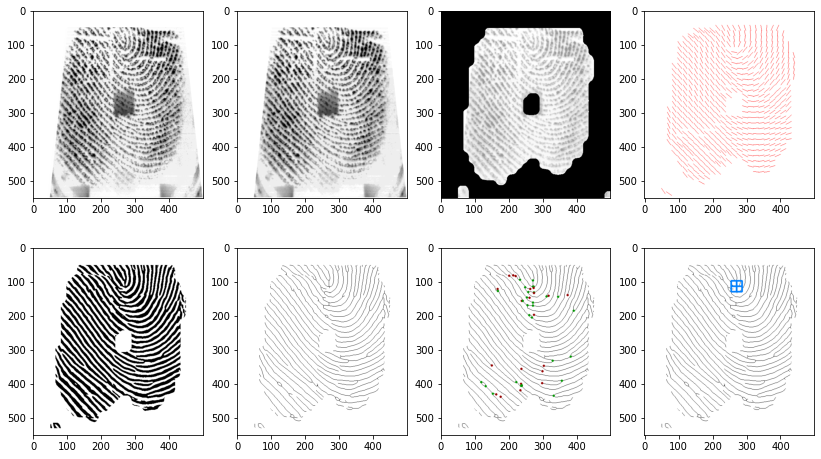

In [19]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1); plt.imshow(input_r_bad, cmap='gray');
plt.subplot(2,4,2); plt.imshow(processed_rb_img['normalized_img'], cmap='gray')
plt.subplot(2,4,3); plt.imshow(processed_rb_img['segmented_img'], cmap='gray');
plt.subplot(2,4,4); plt.imshow(processed_rb_img['orientation_img']);
plt.subplot(2,4,5); plt.imshow(processed_rb_img['gabor_img'], cmap='gray');
plt.subplot(2,4,6); plt.imshow(processed_rb_img['thin_image'], cmap='gray');
plt.subplot(2,4,7); plt.imshow(processed_rb_img['minutiae_img']);
plt.subplot(2,4,8); plt.imshow(processed_rb_img['singularities_img']);

#### Left (Good)

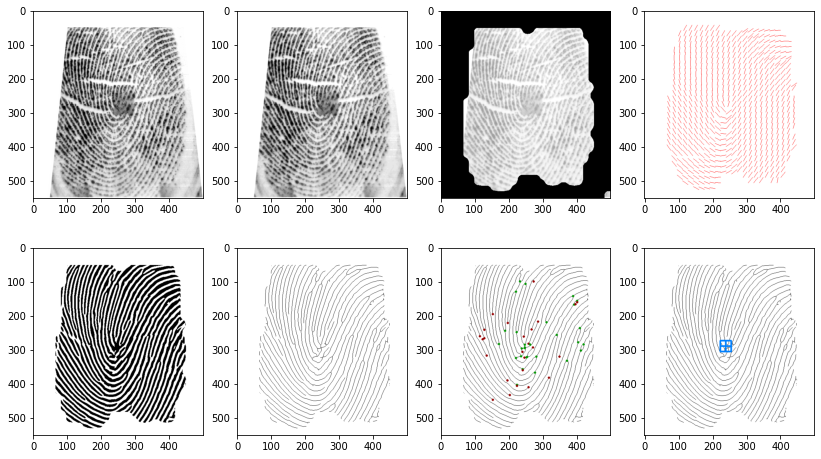

In [20]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1); plt.imshow(input_l_good, cmap='gray');
plt.subplot(2,4,2); plt.imshow(processed_lg_img['normalized_img'], cmap='gray')
plt.subplot(2,4,3); plt.imshow(processed_lg_img['segmented_img'], cmap='gray');
plt.subplot(2,4,4); plt.imshow(processed_lg_img['orientation_img']);
plt.subplot(2,4,5); plt.imshow(processed_lg_img['gabor_img'], cmap='gray');
plt.subplot(2,4,6); plt.imshow(processed_lg_img['thin_image'], cmap='gray');
plt.subplot(2,4,7); plt.imshow(processed_lg_img['minutiae_img']);
plt.subplot(2,4,8); plt.imshow(processed_lg_img['singularities_img']);

#### Left (Bad)

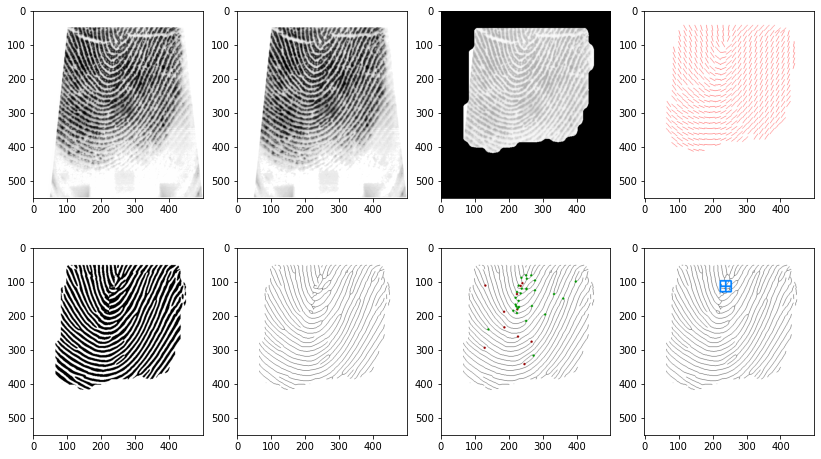

In [21]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1); plt.imshow(input_l_bad, cmap='gray');
plt.subplot(2,4,2); plt.imshow(processed_lb_img['normalized_img'], cmap='gray')
plt.subplot(2,4,3); plt.imshow(processed_lb_img['segmented_img'], cmap='gray');
plt.subplot(2,4,4); plt.imshow(processed_lb_img['orientation_img']);
plt.subplot(2,4,5); plt.imshow(processed_lb_img['gabor_img'], cmap='gray');
plt.subplot(2,4,6); plt.imshow(processed_lb_img['thin_image'], cmap='gray');
plt.subplot(2,4,7); plt.imshow(processed_lb_img['minutiae_img']);
plt.subplot(2,4,8); plt.imshow(processed_lb_img['singularities_img']);

### Conclusion (Ex. 2)

After de-noising the number of minutiae increased in some cases and decreased in some but there was no specific pattern in which the values changed for different fingerprints. However there is one thing in common that the number of singularities remains same as without the de-noising step.

## Exercise 3

#### Changing the "block_size" for Right Thumb Good Image

In [22]:
print("Before changing block_size")
fp_good = fingerprint_processing(right_good, block_size=16, threshold=0.4) #block_size=16, threshold=0.4

#changing block_size
print("\nAfter changing block_size")
fp_good_changed = fingerprint_processing(right_good, block_size=10, threshold=0.4) #block_size=10, threshold=0.4

Before changing block_size
Total of minutiae detected: 47
Total of singularities detected: 4

After changing block_size
Total of minutiae detected: 616
Total of singularities detected: 4


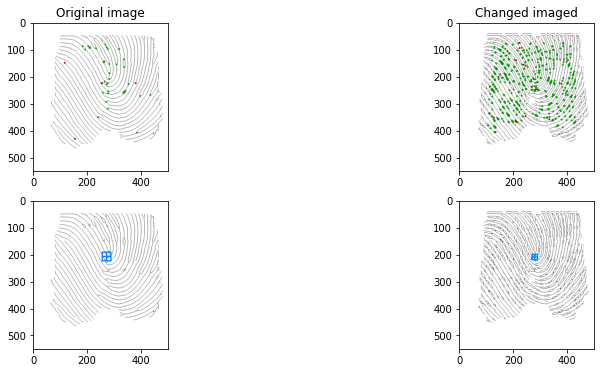

In [23]:
img = fp_good['minutiae_img']
img_change = fp_good_changed['minutiae_img']

img2 = fp_good['singularities_img']
img_change2 = fp_good_changed['singularities_img']


plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(img_change); plt.title('Changed imaged');

# Plotting Singularities
plt.subplot(2,2,3)
plt.imshow(img2); 
plt.subplot(2,2,4)
plt.imshow(img_change2);

#### Changing the "threshold" for Right Thumb Good Image

In [24]:
print("Before changing threshold")
fp_good = fingerprint_processing(right_good, block_size=16, threshold=0.4) #block_size=16, threshold=0.4

#changing threshold
print("\nAfter changing threshold")
fp_good_changed = fingerprint_processing(right_good, block_size=16, threshold=0.5) #block_size=16, threshold=0.5

Before changing threshold
Total of minutiae detected: 47
Total of singularities detected: 4

After changing threshold
Total of minutiae detected: 40
Total of singularities detected: 4


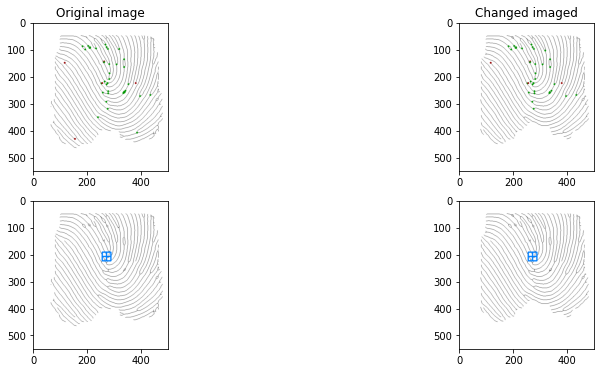

In [25]:
img = fp_good['minutiae_img']
img_change = fp_good_changed['minutiae_img']

img2 = fp_good['singularities_img']
img_change2 = fp_good_changed['singularities_img']


plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(img_change); plt.title('Changed imaged');

# Plotting Singularities
plt.subplot(2,2,3)
plt.imshow(img2); 
plt.subplot(2,2,4)
plt.imshow(img_change2);

#### Changing the "block_size" for Right Thumb Bad Image

In [26]:
print("Before changing block_size")
fp_good = fingerprint_processing(right_bad, block_size=16, threshold=0.4) #block_size=16, threshold=0.4

#changing block_size
print("\nAfter changing block_size")
fp_good_changed = fingerprint_processing(right_bad, block_size=10, threshold=0.4) #block_size=10, threshold=0.4

Before changing block_size
Total of minutiae detected: 61
Total of singularities detected: 4

After changing block_size
Total of minutiae detected: 580
Total of singularities detected: 4


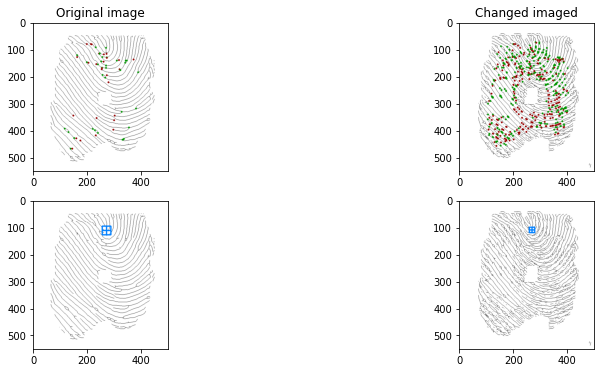

In [27]:
img = fp_good['minutiae_img']
img_change = fp_good_changed['minutiae_img']

img2 = fp_good['singularities_img']
img_change2 = fp_good_changed['singularities_img']


plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(img_change); plt.title('Changed imaged');

# Plotting Singularities
plt.subplot(2,2,3)
plt.imshow(img2); 
plt.subplot(2,2,4)
plt.imshow(img_change2);

#### Changing the "threshold" for Right Thumb Bad Image

In [28]:
print("Before changing threshold")
fp_good = fingerprint_processing(right_bad, block_size=16, threshold=0.4) #block_size=16, threshold=0.4

#changing threshold
print("\nAfter changing threshold")
fp_good_changed = fingerprint_processing(right_bad, block_size=16, threshold=0.5) #block_size=16, threshold=0.5

Before changing threshold
Total of minutiae detected: 61
Total of singularities detected: 4

After changing threshold
Total of minutiae detected: 56
Total of singularities detected: 4


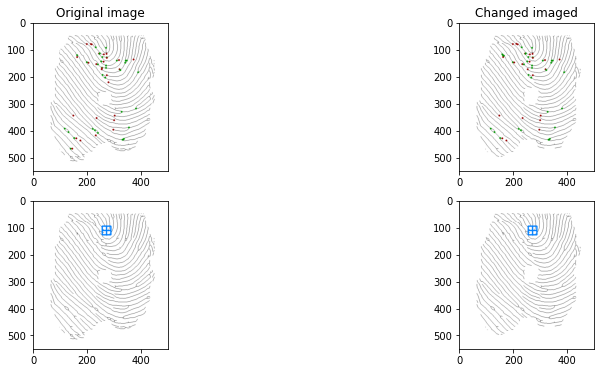

In [29]:
img = fp_good['minutiae_img']
img_change = fp_good_changed['minutiae_img']

img2 = fp_good['singularities_img']
img_change2 = fp_good_changed['singularities_img']


plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(img_change); plt.title('Changed imaged');

# Plotting Singularities
plt.subplot(2,2,3)
plt.imshow(img2); 
plt.subplot(2,2,4)
plt.imshow(img_change2);

#### Changing the "block_size" for Left Thumb Good Image

In [30]:
print("Before changing block_size")
fp_good = fingerprint_processing(left_good, block_size=16, threshold=0.4) #block_size=16, threshold=0.4

#changing block_size
print("\nAfter changing block_size")
fp_good_changed = fingerprint_processing(left_good, block_size=10, threshold=0.4) #block_size=10, threshold=0.4

Before changing block_size
Total of minutiae detected: 64
Total of singularities detected: 4

After changing block_size
Total of minutiae detected: 419
Total of singularities detected: 4


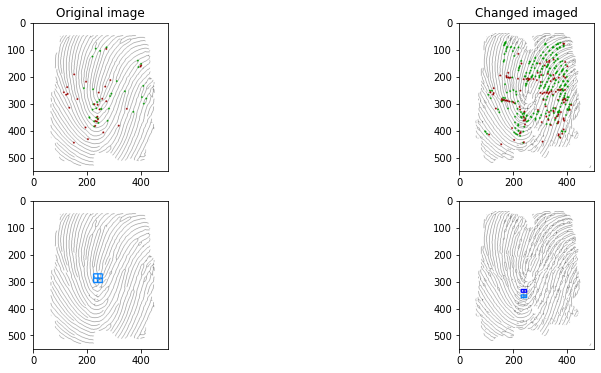

In [31]:
img = fp_good['minutiae_img']
img_change = fp_good_changed['minutiae_img']

img2 = fp_good['singularities_img']
img_change2 = fp_good_changed['singularities_img']


plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(img_change); plt.title('Changed imaged');

# Plotting Singularities
plt.subplot(2,2,3)
plt.imshow(img2); 
plt.subplot(2,2,4)
plt.imshow(img_change2);

#### Changing the "threshold" for Left Thumb Good Image

In [32]:
print("Before changing threshold")
fp_good = fingerprint_processing(left_good, block_size=16, threshold=0.4) #block_size=16, threshold=0.4

#changing threshold
print("\nAfter changing threshold")
fp_good_changed = fingerprint_processing(left_good, block_size=16, threshold=0.5) #block_size=16, threshold=0.5

Before changing threshold
Total of minutiae detected: 64
Total of singularities detected: 4

After changing threshold
Total of minutiae detected: 46
Total of singularities detected: 0


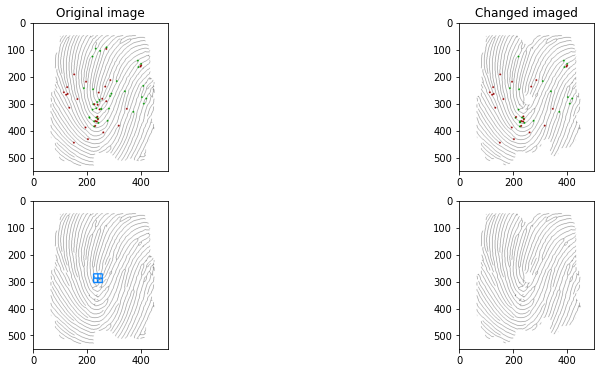

In [33]:
img = fp_good['minutiae_img']
img_change = fp_good_changed['minutiae_img']

img2 = fp_good['singularities_img']
img_change2 = fp_good_changed['singularities_img']


plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(img_change); plt.title('Changed imaged');

# Plotting Singularities
plt.subplot(2,2,3)
plt.imshow(img2); 
plt.subplot(2,2,4)
plt.imshow(img_change2);

#### Changing the "block_size" for Left Thumb Bad Image

In [34]:
print("Before changing block_size")
fp_good = fingerprint_processing(left_bad, block_size=16, threshold=0.4) #block_size=16, threshold=0.4

#changing block_size
print("\nAfter changing block_size")
fp_good_changed = fingerprint_processing(left_bad, block_size=10, threshold=0.4) #block_size=10, threshold=0.4

Before changing block_size
Total of minutiae detected: 44
Total of singularities detected: 4

After changing block_size
Total of minutiae detected: 364
Total of singularities detected: 4


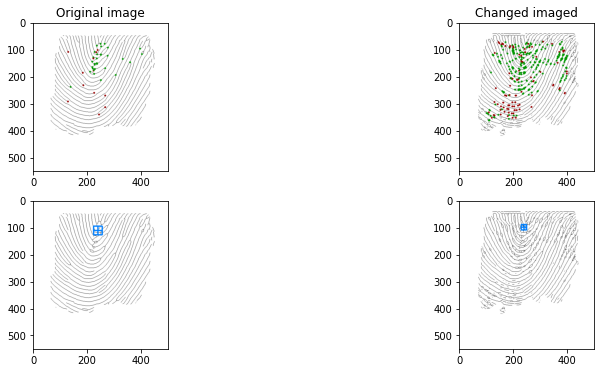

In [35]:
img = fp_good['minutiae_img']
img_change = fp_good_changed['minutiae_img']

img2 = fp_good['singularities_img']
img_change2 = fp_good_changed['singularities_img']


plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(img_change); plt.title('Changed imaged');

# Plotting Singularities
plt.subplot(2,2,3)
plt.imshow(img2); 
plt.subplot(2,2,4)
plt.imshow(img_change2);

#### Changing the "threshold" for Left Thumb Bad Image

In [36]:
print("Before changing threshold")
fp_good = fingerprint_processing(left_bad, block_size=16, threshold=0.4) #block_size=16, threshold=0.4

#changing threshold
print("\nAfter changing threshold")
fp_good_changed = fingerprint_processing(left_bad, block_size=16, threshold=0.5) #block_size=16, threshold=0.5

Before changing threshold
Total of minutiae detected: 44
Total of singularities detected: 4

After changing threshold
Total of minutiae detected: 44
Total of singularities detected: 4


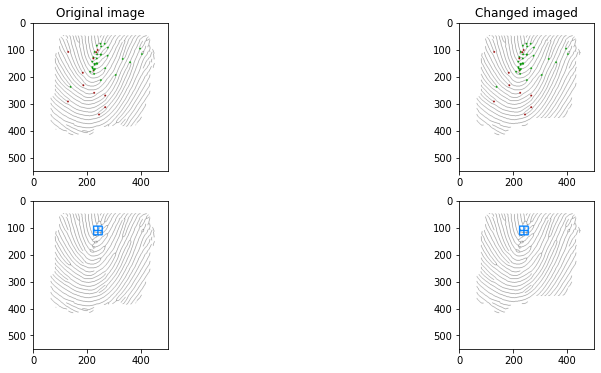

In [37]:
img = fp_good['minutiae_img']
img_change = fp_good_changed['minutiae_img']

img2 = fp_good['singularities_img']
img_change2 = fp_good_changed['singularities_img']


plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.imshow(img); plt.title('Original image')
plt.subplot(2,2,2)
plt.imshow(img_change); plt.title('Changed imaged');

# Plotting Singularities
plt.subplot(2,2,3)
plt.imshow(img2); 
plt.subplot(2,2,4)
plt.imshow(img_change2);

### Conclusion (Ex.3)

From the above results it can be seen that decreasing the block_size increased the number of minutiae by a large proportion while on increasing the threshold the number of minutiae decreased by a small amount. However, in almost all cases, it can be seen that the number of singularities remain unchanged.